In [ ]:
# other stuff
# from EK_modified import edmonds_karp
#
# import networkx as nx
#
# G = nx.DiGraph()
# G.add_edge("x", "a", capacity=3.0)
# G.add_edge("x", "b", capacity=1.0)
# G.add_edge("a", "c", capacity=3.0)
# G.add_edge("b", "c", capacity=5.0)
# G.add_edge("b", "d", capacity=4.0)
# G.add_edge("d", "e", capacity=2.0)
# G.add_edge("c", "y", capacity=2.0)
# G.add_edge("e", "y", capacity=3.0)
#
# R = edmonds_karp(G, "x", "y")
# flow_value = nx.maximum_flow_value(G, "x", "y")
# print(flow_value)
#
# flow_value == R.graph["flow_value"]
#
# print(flow_value)


In [181]:
# importing libraries
import copy

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tabulate import tabulate

In [138]:
# importing data & viewing
raw_data = pd.read_csv('./data/data_v1.csv')
print("Shape:", raw_data.shape)
print(raw_data.head())


Shape: (17, 7)
   Arbitrator_id  Arbitrator_seniority Arbitrator_background  \
0              1                    18     Quantity Surveyor   
1              1                    18     Quantity Surveyor   
2              1                    18     Quantity Surveyor   
3              1                    18     Quantity Surveyor   
4              2                    18              Engineer   

   Arbitrator_total_accepted_cases          Case_nature  Case_dispute_amount  \
0                                1    Construction_Case                12500   
1                                1    Construction_Case               100000   
2                                1    Construction_Case                72080   
3                                1  Building Management                50000   
4                                5    Construction_Case                 4500   

   Case_accepted  
0              1  
1              0  
2              0  
3              0  
4              1  


In [139]:
# onehot enocoding categorical data
mod1_data = raw_data.astype({'Arbitrator_id': 'object'})
mod2_data = mod1_data.copy()
for col in mod1_data.columns:
    if mod1_data.dtypes[col] == "object":
        mod1_data[col] = LabelEncoder().fit_transform(mod1_data[col])
        n = np.max(mod1_data[col])
        tempCol = torch.nn.functional.one_hot(torch.from_numpy(mod1_data[col].to_numpy()), int(n) + 1)
        tempCol = torch.transpose(tempCol, 0, 1).tolist()
        mod2_data.drop(columns=col, inplace=True)

        for i in range(len(tempCol)):
            mod2_data[col+"_"+str(i)] = tempCol[i]
            
# print(raw_data.head())
# print(mod1_data.head())
mod2_data

,Arbitrator_seniority,Arbitrator_total_accepted_cases,Case_dispute_amount,Case_accepted,Arbitrator_id_0,Arbitrator_id_1,Arbitrator_id_2,Arbitrator_id_3,Arbitrator_id_4,Arbitrator_id_5,Arbitrator_id_6,Arbitrator_background_0,Arbitrator_background_1,Arbitrator_background_2,Arbitrator_background_3,Case_nature_0,Case_nature_1
0,18,1,12500,1,1,0,0,0,0,0,0,0,0,0,1,0,1
1,18,1,100000,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,18,1,72080,0,1,0,0,0,0,0,0,0,0,0,1,0,1
3,18,1,50000,0,1,0,0,0,0,0,0,0,0,0,1,1,0
4,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
5,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
6,18,5,12500,1,0,1,0,0,0,0,0,0,1,0,0,0,1
7,18,5,40000,1,0,1,0,0,0,0,0,0,1,0,0,0,1
8,18,5,4500,1,0,1,0,0,0,0,0,0,1,0,0,1,0
9,18,5,49066,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [140]:
# splitting into train:test (K-fold)
data_split = [0.8, 0.2]
N = mod2_data.shape[0]
train_size = int(N*data_split[0])

train = mod2_data[:train_size]
test = mod2_data[train_size:]

print("train:", train.shape)
print("test:", test.shape)

Ytrain = train.loc[:, 'Case_accepted']
Xtrain = train.drop(columns='Case_accepted')

Ytest = test.loc[:, 'Case_accepted']
Xtest = test.drop(columns='Case_accepted')

train: (13, 17)
test: (4, 17)


In [141]:
# normalizing data
scaler = StandardScaler().fit(Xtrain)
preNormalized = Xtrain
Xtrain = scaler.transform(Xtrain)

In [142]:
Xtrain

array([[ 0.42640143, -1.24354001, -0.55300727,  1.5       , -1.08012345,
        -0.42640143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.08012345, -0.42640143,  1.5       , -0.42640143,
         0.42640143],
       [ 0.42640143, -1.24354001,  0.79500765,  1.5       , -1.08012345,
        -0.42640143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.08012345, -0.42640143,  1.5       , -0.42640143,
         0.42640143],
       [ 0.42640143, -1.24354001,  0.36487534,  1.5       , -1.08012345,
        -0.42640143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.08012345, -0.42640143,  1.5       , -0.42640143,
         0.42640143],
       [ 0.42640143, -1.24354001,  0.02471341,  1.5       , -1.08012345,
        -0.42640143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.08012345, -0.42640143,  1.5       ,  2.34520788,
        -2.34520788],
       [ 0.42640143,  0.91192934, -0

In [143]:
# converting to tensors
Xtrain = torch.from_numpy(Xtrain)
Ytrain = torch.from_numpy(Ytrain.to_numpy())

Xtest = torch.from_numpy(Xtest.to_numpy())
Ytest = torch.from_numpy(Ytest.to_numpy())

In [144]:
# defining dataset 
class ArbitratorDataset(Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [145]:
# creating train and valid dataset
train_ds = ArbitratorDataset(Xtrain, Ytrain)
test_ds = ArbitratorDataset(Xtest, Ytest)

In [227]:
# defining model

class CaseArbitrationModel(nn.Module):
    def __init__(self, inp_size):
        super().__init__()  
        self.bn0 = nn.BatchNorm1d(16)
        
        self.lin1 = nn.Linear(inp_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.lin2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.lin3 = nn.Linear(32, 8)
        self.bn3 = nn.BatchNorm1d(8)
        
        self.lin4 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.drops = nn.Dropout(0.3)

    def forward(self, x):
        x = self.bn0(x)
        
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn1(x)
        
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn2(x)
        
        x = F.relu(self.lin3(x))
        x = self.drops(x)
        x = self.bn3(x)
        
        x = self.lin4(x)
        x = self.sigmoid(x)
        
        return x



In [147]:
def test(model, testloader, device, return_softmax=False):
    all_preds = torch.LongTensor().to(device)
    all_targets = torch.LongTensor().to(device)

    if return_softmax:
        all_outs = torch.FloatTensor().to(device)

    model.to(device)

    with torch.no_grad():
        for data in testloader:

            inputs, labels = data[0], data[1]

            inputs = inputs.to(device).float()      
            labels = labels.view(-1, 1)
            labels = labels.to(device).float()

            outputs = model(inputs)

            if return_softmax:
                all_outs = torch.cat((all_outs, outputs.data), 0) 

            if len(outputs.data) == 0:
                continue
            
            pred = torch.round(outputs)
#             print("outs:", outputs)
#             print("predicted:", pred)
#             print("labels:", labels)
#             print("~~~~~~~~~~~~~~~~")
            all_preds = torch.cat((all_preds, pred), 0)
            all_targets = torch.cat((all_targets, labels), 0) 
#     print("------------------------")
    return all_preds, all_targets

In [169]:
# script copied from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
# author: Stefano Nardo, Github: stefanonardo
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [230]:
# defining training process
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss_fn = nn.BCELoss()

k_folds = 5
results = {}


kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_ds)):
    
    earlyStopping = EarlyStopping(patience=20)
    
    model = CaseArbitrationModel(16)
    model.to(device)
    
    all_loss = []
    all_valid_acc = []
    all_train_acc = []
    
    best_model_weights = None
    best_acc = -1

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = DataLoader(train_ds, batch_size=2, sampler=train_subsampler, drop_last=True)
    validloader = DataLoader(train_ds, batch_size=2, sampler=test_subsampler, drop_last=True)
    
    epoch = 0
    while epoch < 100:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device).float()      
            labels = labels.view(2, 1)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            loss.sum().backward()
            optimizer.step()

            #print statistics - have to get more of these
            running_loss += loss.sum().item()
            all_loss.append(loss.sum().item())
            if (i) % 4 == 0:
                #every 4 batch print - loss, training acc, validation acc
                train_pred, train_target = test(model, trainloader, device)
                valid_pred, valid_target = test(model, validloader, device)
                train_acc = accuracy_score(train_target.cpu(), train_pred.cpu())
                valid_acc = accuracy_score(valid_target.cpu(), valid_pred.cpu()) 

                all_train_acc.append(train_acc)
                all_valid_acc.append(valid_acc)

                print('Running Training Loss:', running_loss)
                print('Training Accuracy:', train_acc)
                print('Valid Accuracy:', valid_acc)
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
                model.load_state_dict(best_model_weights)
                print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
                running_loss = 0.0
        
        #early stopping checked every epoch rather than every minibatch
        if earlyStopping is not None and earlyStopping.step(valid_acc):
            break
            
        epoch += 1
    print('Finished Training')
    
    # fold accuracy
    valid_pred, valid_target = test(model, validloader, device)
    valid_acc = accuracy_score(valid_target.cpu(), valid_pred.cpu())
    
    train_pred, train_target = test(model, trainloader, device)
    train_acc = accuracy_score(train_target.cpu(), train_pred.cpu())
    
    results[str(fold)+"_vc"] = valid_acc
    results[str(fold)+"_tc"] = train_acc
    
    print('################################')

Running Training Loss: 0.9978708028793335
Training Accuracy: 0.5
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.3135910034179688
Training Accuracy: 0.5
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.6073716282844543
Training Accuracy: 0.5
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 3.0886112451553345
Training Accuracy: 0.5
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.8136295080184937
Training Accuracy: 0.4
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.748876631259918
Training Accuracy: 0.3
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.563300609588623
Training Accuracy: 0.6
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.454169750213623
Training Accuracy: 0.3
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.518302321434021
Training Accuracy: 0.6
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~

Running Training Loss: 2.816349148750305
Training Accuracy: 0.3
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.65107262134552
Training Accuracy: 0.4
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 3.007085680961609
Training Accuracy: 0.3
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.6700827479362488
Training Accuracy: 0.4
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.98842054605484
Training Accuracy: 0.5
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.7710856795310974
Training Accuracy: 0.5
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.7930373549461365
Training Accuracy: 0.5
Valid Accuracy: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.6420016884803772
Training Accuracy: 0.3
Valid Accuracy: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.8240320682525635
Training Accuracy: 0.3
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~

Running Training Loss: 0.3975798487663269
Training Accuracy: 0.9
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.498088300228119
Training Accuracy: 0.7
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.7893856763839722
Training Accuracy: 0.4
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.299048662185669
Training Accuracy: 0.3
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.6465816497802734
Training Accuracy: 0.7
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.6734614968299866
Training Accuracy: 0.6
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 1.0674948692321777
Training Accuracy: 0.7
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 3.0752683877944946
Training Accuracy: 0.6
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.7564843893051147
Training Accuracy: 0.6
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~

Running Training Loss: 2.9526756405830383
Training Accuracy: 0.4
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.6726842522621155
Training Accuracy: 0.3
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 3.484730541706085
Training Accuracy: 0.5
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.8757896423339844
Training Accuracy: 0.2
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 3.3083728551864624
Training Accuracy: 0.2
Valid Accuracy: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 0.354427695274353
Training Accuracy: 0.4
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Running Training Loss: 2.854694128036499
Training Accuracy: 0.4
Valid Accuracy: 1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~
Finished Training
################################


In [218]:
# fold statistics - 2 layer model
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')

table = []
sum_vc = 0.0
sum_tc = 0.0
for i in range(k_folds):
    tc = results[str(i)+"_tc"]
    vc = results[str(i)+"_vc"]
    table.append([f'Fold {i}', tc, vc])
    sum_tc += tc
    sum_vc += vc

table.append(["Average:", sum_tc/k_folds, sum_vc/k_folds])
print(tabulate(table, headers=["Fold", "Train Acc.", "Valid Acc."]))

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold        Train Acc.    Valid Acc.
--------  ------------  ------------
Fold 0            0.6            1
Fold 1            0.4            0.5
Fold 2            0.4            0.5
Fold 3            0.1            1
Fold 4            0.7            1
Average:          0.44           0.8


In [222]:
# fold statistics - 3 layer model
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')

table = []
sum_vc = 0.0
sum_tc = 0.0
for i in range(k_folds):
    tc = results[str(i)+"_tc"]
    vc = results[str(i)+"_vc"]
    table.append([f'Fold {i}', tc, vc])
    sum_tc += tc
    sum_vc += vc

table.append(["Average:", sum_tc/k_folds, sum_vc/k_folds])
print(tabulate(table, headers=["Fold", "Train Acc.", "Valid Acc."]))

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold        Train Acc.    Valid Acc.
--------  ------------  ------------
Fold 0            0.3            0.5
Fold 1            0.7            0.5
Fold 2            0.6            0.5
Fold 3            0.5            0
Fold 4            0.7            0.5
Average:          0.56           0.4


In [231]:
# fold statistics - 4 layer model
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')

table = []
sum_vc = 0.0
sum_tc = 0.0
for i in range(k_folds):
    tc = results[str(i)+"_tc"]
    vc = results[str(i)+"_vc"]
    table.append([f'Fold {i}', tc, vc])
    sum_tc += tc
    sum_vc += vc

table.append(["Average:", sum_tc/k_folds, sum_vc/k_folds])
print(tabulate(table, headers=["Fold", "Train Acc.", "Valid Acc."]))

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold        Train Acc.    Valid Acc.
--------  ------------  ------------
Fold 0            0.3            1
Fold 1            0.5            0.5
Fold 2            0.8            0.5
Fold 3            0.6            0.5
Fold 4            0.4            1
Average:          0.52           0.7


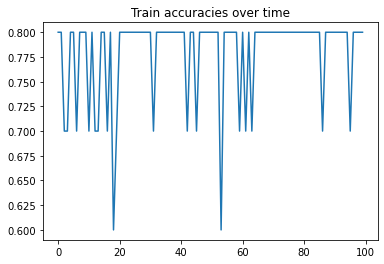

In [60]:
# plotting training accuracy over time

x = np.arange(len(all_train_acc))
plt.plot(x, all_train_acc)
plt.title("Train accuracies over time")
plt.show()

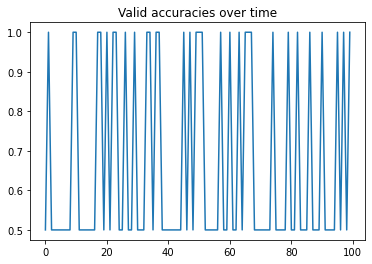

In [61]:
# plotting validation accuracy over time

x = np.arange(len(all_valid_acc))
plt.plot(x, all_valid_acc)
plt.title("Valid accuracies over time")
plt.show()

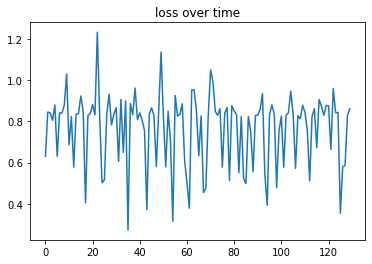

In [232]:
# plotting validation accuracy over time

x = np.arange(len(all_loss))
plt.plot(x, all_loss)
plt.title("loss over time")
plt.show()

In [ ]:
# testing with test dl
sums = 0.0
for i in range(100):
    test_pred, test_target = test(model, test_dl, device)
    test_acc = accuracy_score(test_target.cpu(), test_pred.cpu())
    sums += test_acc
print("test accuracy:", sums/100)